In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from utils.User_Classes import UserClass
from utils.tools import calculate_margin, calculate_price_index
from utils.clairvoyant_tools import find_optimal_bid_for_class
from utils.learners.GPTS_Learner import GPTS_Learner
from utils.learners.GPUCB_Learner import GPUCB_Learner
from p2.new_bidding_enviroment import Bidding_Environment_2 as BiddingEnvironment

import warnings
warnings.filterwarnings("ignore")

# Environment

In [7]:
#Environment
n_arms = 100
min_bid = 0.01
max_bid = 3.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 200
cost_sigma = 10


user = UserClass(name='C1')

price = 150
T = 10
n_experiments = 10

gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []


optimum_bid = find_optimal_bid_for_class(user.user_index, calculate_price_index(price))
optimum_bid

(1.1274747474747475, 5080.849095727814)

# Experiment

In [8]:
for e in tqdm(range(n_experiments)):
    env = BiddingEnvironment(bids=bids, clicks_sigma=sigma, cost_sigma=cost_sigma, user_class=user, n_arms=n_arms)
    gpts_learner = GPTS_Learner(n_arms, arms=bids)
    gpucb_learner = GPUCB_Learner(n_arms, arms=bids)

    for t in range(T):
        #GP Thompson Sampling
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

        #GP Upper Confidence Bounds
        pulled_arm = gpucb_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpucb_learner.update(pulled_arm, reward)

    gpts_rewards_per_experiment.append(gpts_learner.collected_rewards)
    gpucb_rewards_per_experiment.append(gpucb_learner.collected_rewards)

100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


In [9]:
gpts_rewards_per_experiment

[array([9402.7191331 , 6821.81015139, 7180.33725236, 5685.09367567,
        3860.40357276, 4891.74632715, 6881.66778304, 3870.1252324 ,
        4896.99850108, 8218.63004653]),
 array([ 5658.3304242 ,  9770.04761842,  4635.51129031,   782.46929485,
         2194.81807527,  3702.32805252,  2408.82644552,   238.96581995,
        18293.08667873,   622.96761561]),
 array([ 1936.89159088,  5361.44571789,   238.97581995,  3773.3973911 ,
         6196.01373907,  5946.53742854, 11080.87213749,  4705.61880519,
         4974.94041553,  4896.83121163]),
 array([ 4861.88454942,  4890.45920951,  2352.290294  , 13681.77532385,
         5127.56565936,  3825.30355442,   238.97581995,  1093.00082795,
         2827.38021724,  3433.2010785 ]),
 array([ 2426.49028878,  2979.16289633,  4287.19099241,  9095.0997541 ,
        18120.85594532,  4895.49892112,  6722.79102043,  4255.17117888,
         1373.26704827,   417.3794202 ]),
 array([ 4447.64389218,  4811.35994078,  5826.25797423,  9106.94164129,
        

# Cumulative Regret
The cumulative regret at a given round (in our case day) t is the sum of the regrets experienced up until and including that day.

## GPTS

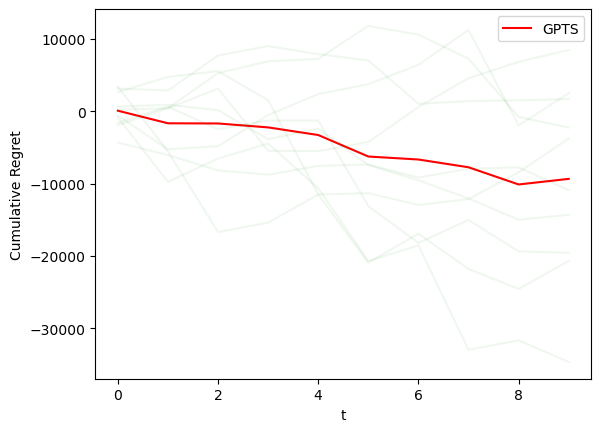

In [10]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid[1] - line, axis=0), "g", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## GPUCB

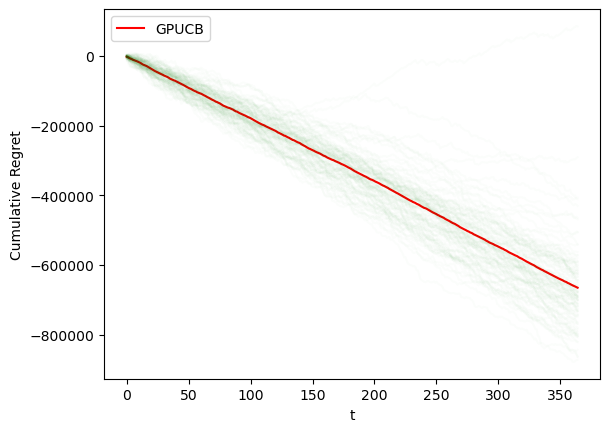

In [6]:
plt.figure(0)
plt.ylabel("Cumulative Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(optimum_bid[1] - gpucb_rewards_per_experiment, axis=0)), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(optimum_bid[1] - line, axis=0), "g", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

# Cumulative Reward

The cumulative reward at a given round (in our case day) t is the sum of the rewards received up until and including that day.

## GPTS

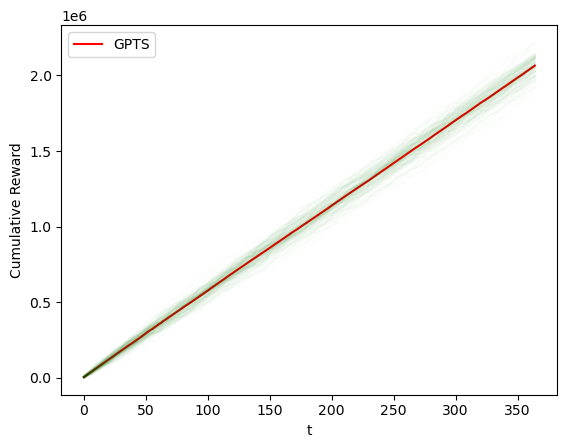

In [7]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "g", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

## GPUCB

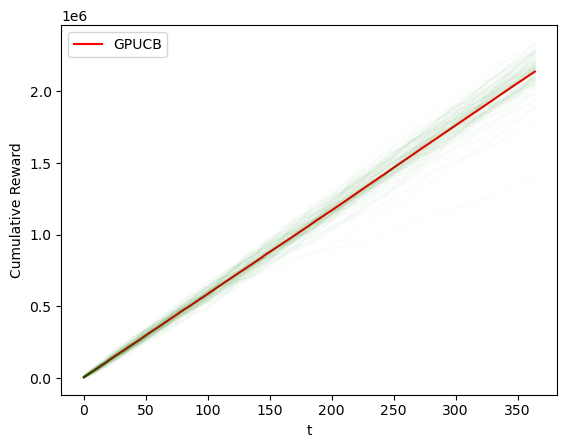

In [8]:
plt.figure(0)
plt.ylabel("Cumulative Reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpucb_rewards_per_experiment, axis=0)), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(np.nancumsum(line, axis=0), "g", alpha=0.3 / np.power(len(gpucb_rewards_per_experiment), 2/3))

plt.legend()
plt.show()

# Istantaneous Regret
Instantaneous regret is a measure of how much better you could have done on a particular day t if you had made the optimal decisions (as determined by your clairvoyant optimization algorithm). It's defined as the difference between the optimal reward and the actual reward received on day t.



## GPTS

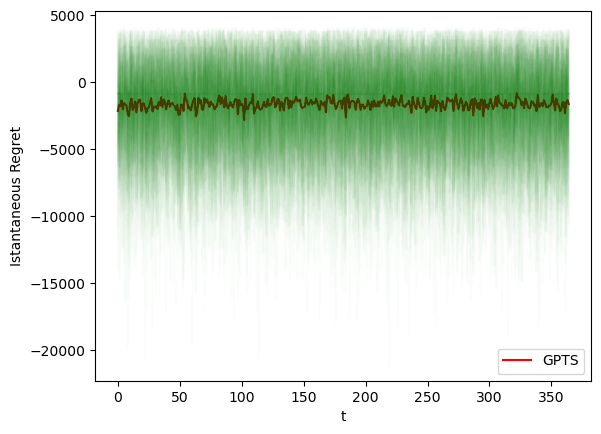

In [9]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid[1] - gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for index, line in enumerate(gpts_rewards_per_experiment):
        plt.plot(optimum_bid[1] - line, "g",  alpha=0.3 / np.power(len(gpts_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

## GPUCB

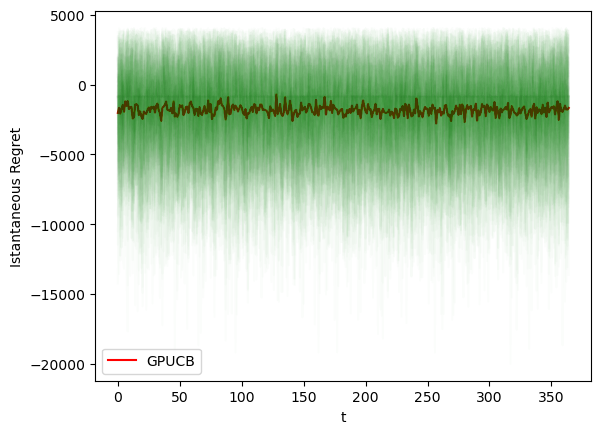

In [10]:
plt.figure(0)
plt.ylabel("Istantaneous Regret")
plt.xlabel("t")
plt.plot(np.mean(optimum_bid[1] - gpucb_rewards_per_experiment, axis=0), 'r', label='GPUCB')
for index, line in enumerate(gpucb_rewards_per_experiment):
        plt.plot(optimum_bid[1] - line, "g",  alpha=0.3 / np.power(len(gpucb_rewards_per_experiment) , 2/3))
plt.legend()
plt.show()

# Istantaneous Reward
The instantaneous reward at a given round (or day) t would be the reward received on that particular day.

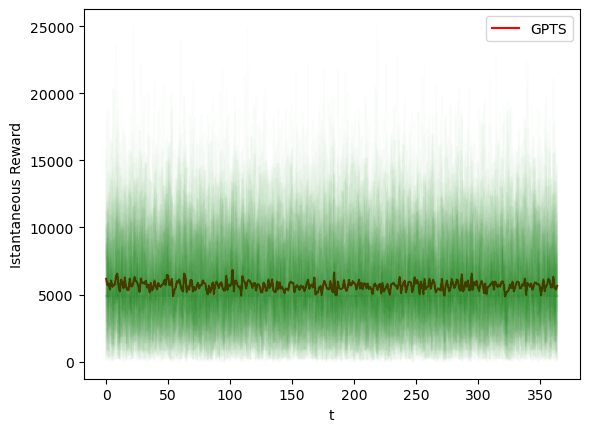

In [11]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r', label='GPTS')
for line in gpts_rewards_per_experiment:
    plt.plot(line, "g", alpha=0.3 / np.power(len(gpts_rewards_per_experiment), 2/3))
plt.legend()
plt.show()

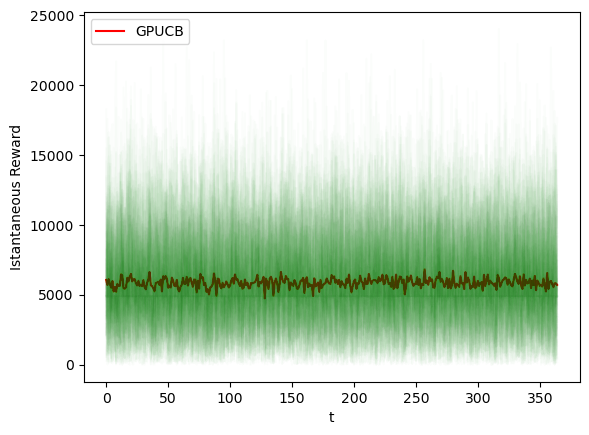

In [12]:
plt.figure(0)
plt.ylabel("Istantaneous Reward")
plt.xlabel("t")
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'r', label='GPUCB')
for line in gpucb_rewards_per_experiment:
    plt.plot(line, "g", alpha=0.3 / np.power(len(gpucb_rewards_per_experiment), 2/3))
plt.legend()
plt.show()